# Download data

In [6]:
import os
from pathlib import Path


challenge = 'digit-recognizer'

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle: path = Path(f'../input/{challenge}')
else:
    path = Path(challenge)
    if not path.exists():
        import zipfile,kaggle
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)
import torch, numpy as np, pandas as pd
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

100%|██████████| 15.3M/15.3M [00:09<00:00, 1.66MB/s]


# Format the Data for pytorch


In [9]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset


class DigitDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.labels = self.data.iloc[:, 0].values
        self.images = self.data.iloc[:, 1:].values.astype(np.float32)
        self.images = self.images.reshape(-1, 28, 28)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label


In [10]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

In [11]:
train_dataset = DigitDataset(csv_file=path/'train.csv', transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

In [13]:
test_data = pd.read_csv(path/'test.csv').values.astype(np.float32).reshape(-1, 28, 28)
test_data = torch.tensor(test_data)
test_data

tensor([[[  0.,   0.,   0.,   0.,   0.,   0.,   0.,  ...,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,  ...,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,  ...,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,  ...,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,  ...,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,  ...,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,  ...,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
         ...,
         [  0.,   0.,   0.,   0.,   6.,  26., 179.,  ...,   0.,  14.,   6.,   0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,  ...,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,  ...,   0.,   0.,   0.,  

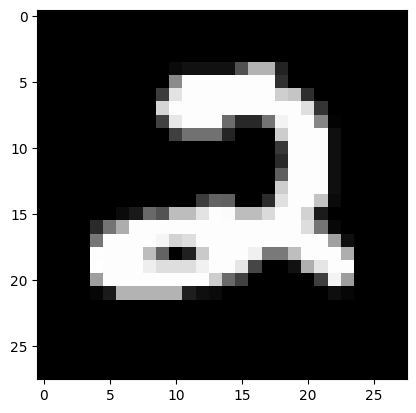

In [20]:
import matplotlib.pyplot as plt

image = test_data[0]
image_np = image.numpy()
plt.imshow(image_np, cmap='gray')
plt.show()

# Make the Neural Net

In [43]:
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 64)
        self.fc5 = nn.Linear(64, 10)
    
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x



# Train the Neural Net

In [45]:
model = MyModel()
crit = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=0.001)
#scheduler = lr_scheduler.StepLR(opt, step_size=50, gamma=0.5)


num_epochs = 20
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        opt.zero_grad()  # Zero the parameter gradients

        outputs = model(images)  # Forward pass
        loss = crit(outputs, labels)  # Calculate loss
        loss.backward()  # Backward pass
        opt.step()  # Update weights

        running_loss += loss.item()  # Accumulate loss

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader)}')



Epoch [1/20], Loss: 0.28795631695184376
Epoch [2/20], Loss: 0.13822807645768245
Epoch [3/20], Loss: 0.10839835872456907
Epoch [4/20], Loss: 0.08906077108093605
Epoch [5/20], Loss: 0.08018821334399714
Epoch [6/20], Loss: 0.07823487989031433
Epoch [7/20], Loss: 0.07059877698661092
Epoch [8/20], Loss: 0.059141738059431
Epoch [9/20], Loss: 0.0560705354564146
Epoch [10/20], Loss: 0.05352371798706779
Epoch [11/20], Loss: 0.052201418049945006
Epoch [12/20], Loss: 0.045547113269226065
Epoch [13/20], Loss: 0.04282024616401458
Epoch [14/20], Loss: 0.0490248425670444
Epoch [15/20], Loss: 0.048775398710787024
Epoch [16/20], Loss: 0.04890358838265193
Epoch [17/20], Loss: 0.03788327081931802
Epoch [18/20], Loss: 0.036447067641223636
Epoch [19/20], Loss: 0.030378833131130892
Epoch [20/20], Loss: 0.03160059187644487


# Prep submission

In [46]:
model.eval()
predictions = []

with torch.no_grad():
    for i in range(0, len(test_data), 64):
        inputs = test_data[i:i+64]
        inputs = inputs.view(-1, 1, 28, 28)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())

submission = pd.DataFrame({
    'ImageId': list(range(1, len(predictions) + 1)),
    'Label': predictions
})


submission.to_csv('submission2.csv', index=False)

In [41]:


def submit_to_kaggle(filepath, comp_name, message):
    # Replace with your actual file path and competition name
    file_path = filepath
    competition_name = comp_name  # Replace with the competition name

    # Command to submit to Kaggle
    command = f'kaggle competitions submit -c {competition_name} -f {file_path} -m "{message}"'

    try:
        output = subprocess.check_output(command, shell=True)
        print(output.decode('utf-8'))  
        
        print("Submission successful!")
    except subprocess.CalledProcessError as e:
        print("Submission failed. Error:", e)


In [47]:
submit_to_kaggle('submission2.csv', challenge, 'First attempt')

100%|██████████| 208k/208k [00:00<00:00, 306kB/s] 


Successfully submitted to Digit Recognizer
Submission successful!
